In [ ]:
# Não é preciso baixar o dataset se essa célula funcionar
# Estou baixando os dados através do gdown
!gdown 1NlfLv1MJhEciBZKN93LoxZCudGPZnE4J

Downloading...
From: https://drive.google.com/uc?id=1NlfLv1MJhEciBZKN93LoxZCudGPZnE4J
To: /content/imdb.csv
100% 66.2M/66.2M [00:00<00:00, 104MB/s] 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
import nltk 
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))   

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lendo os dados

In [ ]:
df = pd.read_csv('imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Os dados são balanceados
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Pré-Processamento

In [ ]:
from bs4 import BeautifulSoup
import re
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def clean(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text
#Apply function on review column
df['review'] = df['review'].progress_apply(clean)

100%|██████████| 50000/50000 [00:25<00:00, 1992.82it/s]


In [ ]:
df['review']

0        One of the other reviewers has mentioned that ...
1        A wonderful little production The filming tech...
2        I thought this was a wonderful way to spend ti...
3        Basically theres a family where a little boy J...
4        Petter Matteis Love in the Time of Money is a ...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot bad dialogue bad acting idiotic direc...
49997    I am a Catholic taught in parochial elementary...
49998    Im going to have to disagree with the previous...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
# Removing stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords]    
    return ' '.join(tokens)

df['review'] = df['review'].progress_apply(remove_stopwords)

100%|██████████| 50000/50000 [00:46<00:00, 1073.08it/s]


In [ ]:
# lower casing
df['review'] = df['review'].progress_apply(lambda text: text.lower())

100%|██████████| 50000/50000 [00:00<00:00, 239390.80it/s]


In [ ]:
df['review']

0        one reviewers mentioned watching 1 oz episode ...
1        a wonderful little production the filming tech...
2        i thought wonderful way spend time hot summer ...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    i thought movie right good job it wasnt creati...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i catholic taught parochial elementary schools...
49998    im going disagree previous comment side maltin...
49999    no one expects star trek movies high art fans ...
Name: review, Length: 50000, dtype: object

### Splitando os dados

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.3, random_state=42
)

## Matriz: document x term

### Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

min_df = 100      # nro minimo de 'document frequency' de um token

max_df = 1.0      # nro máximo de 'document frequency' de um token 
                  #(1.0 incluirá até mesmo tokens com 100% de 'document frequency')

ngram_range = (1,1)
lowercase = True
tokenizer = word_tokenize
max_features = None

vsm_bow = CountVectorizer(
    min_df=min_df, max_df=max_df, ngram_range=ngram_range, lowercase=lowercase,
    tokenizer=tokenizer, max_features=max_features 
)
X_train_bow = vsm_bow.fit_transform(X_train)
X_test_bow = vsm_bow.transform(X_test)

Função para comparar a similaridade entre dois vetores.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

def get_n_most_similar_idxs(
    idx, coocurrence_matrix, n, distance_metric
):
    doc_vec = coocurrence_matrix.getrow(idx)
    similarity = distance_metric(coocurrence_matrix, doc_vec).flatten()
    sign = 1 if distance_metric == euclidean_distances else -1
    return np.argsort(sign * similarity)[:n]

#### Similaridade documentos

In [ ]:
def get_n_most_similar_docs(
    doc_idx, doc_term_matrix, full_doc_term_matrix, vsm, 
    n, distance_metric, max_words_per_doc=15
):
    idxs = get_n_most_similar_idxs(
        doc_idx, doc_term_matrix, n, distance_metric
    )
    return [
        ' '.join(doc[:max_words_per_doc]) 
        for doc in vsm.inverse_transform(full_doc_term_matrix[idxs])
    ]

In [ ]:
import random

def print_n_most_similar_docs(
    doc_term_matrix, full_doc_term_matrix, vsm, n, n_examples   
):
    n_documents = doc_term_matrix.shape[0]

    for i in range(n_examples):
        print(f'Example {i+1}')
        document_idx = random.randint(0, n_documents)
        doc = ' '.join(vsm.inverse_transform(full_doc_term_matrix[document_idx])[0])
        print(f'Doc:{doc}\n')
        print(f'Using Euclidean distance:', end='\n')
        print('\n'.join(get_n_most_similar_docs(
            document_idx, doc_term_matrix, full_doc_term_matrix, 
            vsm, n, euclidean_distances)
        ))
        print(f'\nUsing Cosine similarity:')
        print('\n'.join(get_n_most_similar_docs(
            document_idx, doc_term_matrix, full_doc_term_matrix,
            vsm, n, cosine_similarity))
        )
        print('------'*5)


In [ ]:
n = 5
n_examples = 5
print_n_most_similar_docs(X_train_bow, X_train_bow, vsm_bow, n, n_examples)

Example 1
Doc:i one another new get good like time long big characters its someone setting enjoy well enough jokes lets place live see mile happy weak there looking please instead kids says gags opening virtually different probably entirely seemed children joke put avoid series coming definitely worked em classic amounts footage else unlike road cat example mostly basically involving builds tired returns cartoon boat fails generic chuck introduce endings routine glasses

Using Euclidean distance:
amounts another avoid basically big boat builds cartoon cat characters children chuck classic coming definitely
dont get i know like movie never tired watching well
ago also another best exciting genre i it one opportunity saw see series since starring
boring credits ending glad i long never roll see
filmmakers group hope i never

Using Cosine similarity:
amounts another avoid basically big boat builds cartoon cat characters children chuck classic coming definitely
910 acceptable acting action

In [ ]:
# import random
# n_documents = X_train_bow.shape[0]
# n_examples = 5
# n = 5

# for i in range(n_examples):
#     print(f'Example {i+1}')
#     document_idx = random.randint(0, n_documents)
#     doc = ' '.join(vsm_bow.inverse_transform(X_train_bow[document_idx])[0])
#     print(f'Doc:{doc}\n')
#     print(f'Using Euclidean distance:', end='\n')
#     print('\n'.join(get_n_most_similar_docs(document_idx, X_train_bow, vsm_bow, n, euclidean_distances)))
#     print(f'\nUsing Cosine similarity:')
#     print('\n'.join(get_n_most_similar_docs(document_idx, X_train_bow, vsm_bow, n, cosine_similarity)))
#     print('------'*5)

#### Similaridade palavras

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

def get_n_most_similar_words(
    word_idx, term_doc_matrix, vsm, n, distance_metric
):
    idxs = get_n_most_similar_idxs(
        word_idx, term_doc_matrix, n, distance_metric
    )

    return [
        vsm.get_feature_names_out()[idx] for idx in idxs
    ]

In [ ]:
def print_n_most_similar_words(
    term_doc_matrix, vsm, n, n_examples
):
    n_words = term_doc_matrix.shape[0]
    n_examples = 5
    n = 5

    for i in range(n_examples):
        print(f'Example {i+1}')
        word_idx = random.randint(0, n_words)
        word = vsm.get_feature_names_out()[word_idx]
        print(f'Chosen word: {word}')
        print(f'Using Euclidean distance:', end='')
        print(' '.join(get_n_most_similar_words(word_idx, term_doc_matrix, vsm, n, euclidean_distances)))
        print(f'\nUsing Cosine similarity:', end='')
        print(' '.join(get_n_most_similar_words(word_idx, term_doc_matrix, vsm, n, cosine_similarity)))
        print('------'*5)


In [ ]:
n = 5
n_examples = 5
print_n_most_similar_words(X_train_bow.T, vsm_bow, n, n_examples)

Example 1
Chosen word: randomly
Using Euclidean distance:randomly appropriately hopelessly ensues occasions

Using Cosine similarity:randomly anna random focus supposed
------------------------------
Example 2
Chosen word: thriller
Using Euclidean distance:thriller unfold investigating thrillers ensues

Using Cosine similarity:thriller thrillers suspense the michael
------------------------------
Example 3
Chosen word: final
Using Euclidean distance:final showdown nail destroys inexplicably

Using Cosine similarity:final the one film scene
------------------------------
Example 4
Chosen word: interview
Using Euclidean distance:interview fascination subpar appropriately unfold

Using Cosine similarity:interview interviews documentary fish one
------------------------------
Example 5
Chosen word: vaguely
Using Euclidean distance:vaguely ensues appropriately lengthy fascination

Using Cosine similarity:vaguely remember dating defined even
------------------------------


In [ ]:
# import random
# n_features = X_train_bow.shape[1]
# n_examples = 5
# n = 5

# for i in range(n_examples):
#     print(f'Example {i+1}')
#     word_idx = random.randint(0, n_features)
#     word = vsm_bow.get_feature_names_out()[word_idx]
#     print(f'Chosen word: {word}')
#     print(f'Using Euclidean distance:', end='')
#     print(' '.join(get_n_most_similar_words(word_idx, X_train_bow.transpose(), vsm_bow, n, euclidean_distances)))
#     print(f'\nUsing Cosine similarity:', end='')
#     print(' '.join(get_n_most_similar_words(word_idx, X_train_bow.transpose(), vsm_bow, n, cosine_similarity)))
#     print('------'*5)

#### LSA

##### Matriz document x term

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components = 10

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_bow)

TruncatedSVD(n_components=10, random_state=42)

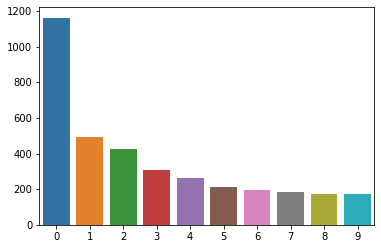

In [ ]:
S = svd.singular_values_
sns.barplot(x=list(range(len(S))), y = S)

In [ ]:
def get_most_important_words(terms, components):
    topic_terms = {}
    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:7]
        topic_terms[i] = sorted_terms
    return topic_terms

In [ ]:
terms = vsm_bow.get_feature_names_out()
topic_terms = get_most_important_words(terms, svd.components_)

In [ ]:
def plot_term_topic(term_comp, n_components):
    fig, axs = plt.subplots(n_components, figsize=(5, n_components*2.05))
    fig.subplots_adjust(hspace=0.8)
    for topic_idx in range(n_components):
        terms = []
        comps = []
        for term, comp in term_comp[topic_idx]:
            terms.append(term)
            comps.append(comp)
        axs[topic_idx].barh(terms, comps)
        axs[topic_idx].set_title(f'Main terms topic {topic_idx+1}')
        axs[topic_idx].set_xlabel(f'Component values')
        axs[topic_idx].set_ylabel(f'Terms')

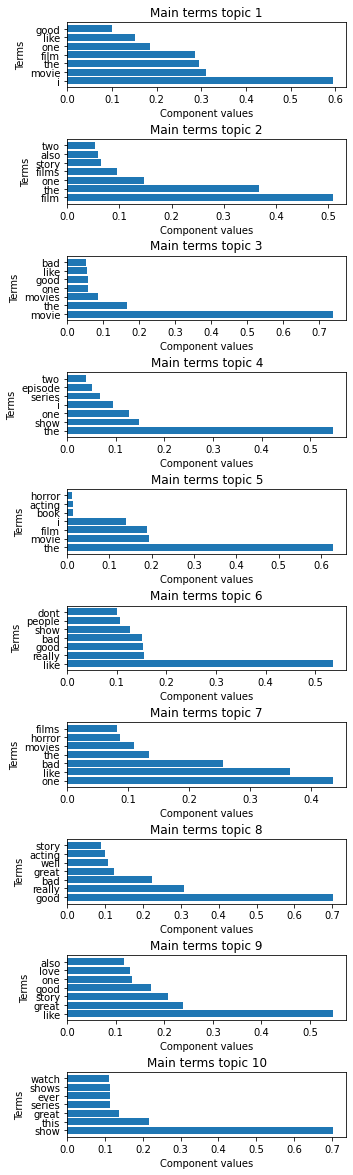

In [ ]:
plot_term_topic(topic_terms, n_components)

In [ ]:
from scipy import sparse
n = 5
n_examples = 5
lsa_X_train_bow = svd.transform(X_train_bow)
lsa_X_train_bow = sparse.csr_matrix(lsa_X_train_bow)

print(lsa_X_train_bow.shape)
print_n_most_similar_docs(lsa_X_train_bow, X_train_bow, vsm_bow, n, n_examples)

(35000, 10)
Example 1
Doc:annoying anything away behind better blair breaking camera car cheap coming compare crap crappy crazy crying directions embarrassing entire everything fair find five get getting girls guess hit home i im in lack literally lost make movie much one painful person piece pretty real scary scene screaming see seem shocking shot sorry sound stays stop store suddenly summary the though top trouble try trying useless violence way well witch word

Using Euclidean distance:
annoying anything away behind better blair breaking camera car cheap coming compare crap crappy crazy
10 2nd actors and around back better bunch cant cared cast characters clever comedic contrived
acting and beings black clumsy coming count even except expect explain family fully fx ghosts
actor adam although and andy any bad big boy by camera case choice college comedies
10 12 8 accents actually and bad chinese choice clearly dialog do done ever figure

Using Cosine similarity:
annoying anything awa

##### Matriz term x document

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components = 10

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_bow.transpose())

TruncatedSVD(n_components=10, random_state=42)

In [ ]:
from scipy import sparse
lsa_terms = svd.transform(X_train_bow.transpose())
lsa_terms = sparse.csr_matrix(lsa_terms)

In [ ]:
n = 5
n_examples = 5
print_n_most_similar_words(lsa_terms, vsm_bow, n, n_examples)

Example 1
Chosen word: finished
Using Euclidean distance:finished grade reviewers hopes months

Using Cosine similarity:finished negative positive seeing went
------------------------------
Example 2
Chosen word: mentioning
Using Euclidean distance:mentioning disjointed chased staring coherent

Using Cosine similarity:mentioning unnecessary cliche make insane
------------------------------
Example 3
Chosen word: wasted
Using Euclidean distance:wasted honestly pathetic 20 werent

Using Cosine similarity:wasted minutes halfway paid 90
------------------------------
Example 4
Chosen word: choose
Using Euclidean distance:choose promise heaven correct angel

Using Cosine similarity:choose ready day took reaction
------------------------------
Example 5
Chosen word: relation
Using Euclidean distance:relation grasp disturbed valuable affect

Using Cosine similarity:relation sexuality sin grasp disturbed
------------------------------


#### Classificação

##### BoW

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_bow, y_train)
clf.score(X_test_bow, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8754666666666666

##### BoW + LSA

In [ ]:
n_components = 200

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_bow)

lsa_X_train_bow = svd.transform(X_train_bow)
lsa_X_test_bow = svd.transform(X_test_bow)

clf = LogisticRegression()
clf.fit(lsa_X_train_bow, y_train)
clf.score(lsa_X_test_bow, y_test)

0.8522

### TF-IDF reweighting

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

min_df = 100      # nro minimo de 'document frequency' de um token

max_df = 1.0      # nro máximo de 'document frequency' de um token 
                  #(1.0 incluirá até mesmo tokens com 100% de 'document frequency')

ngram_range = (1,1)
lowercase = True
tokenizer = word_tokenize
max_features = None

vsm_tfidf = TfidfVectorizer(
    min_df=min_df, max_df=max_df, ngram_range=ngram_range, lowercase=lowercase,
    tokenizer=tokenizer, max_features=max_features 
)

X_train_tfidf = vsm_tfidf.fit_transform(X_train)
X_test_tfidf = vsm_tfidf.transform(X_test)

In [ ]:
X_train_tfidf.shape

(35000, 4754)

#### Similaridade documentos

In [ ]:
n = 5
n_examples = 5
print_n_most_similar_docs(X_train_tfidf, X_train_tfidf, vsm_tfidf, n, n_examples)

Example 1
Doc:glenn personality heroic hopelessly credible pops countless hilariously sharp likewise waters guide cousin subsequent disbelief chase neck trade mouth naturally sky dreadful charisma wooden sheriff raw outfit motion conclusion teens resort severely previously comparison painfully abysmal staged relief rank baby construction discover vicious wound immediately r overall authentic artist community secondary subplot crashes alltime animation comic displays extended feels falls water quiet criminal cash ruins television laughing eating human concerning exploitation nobody arent creature pictures david theater clueless features antics leads idiotic causing albeit our solid atmosphere scared stupid released mark thrilling richard completely saturday certain particularly eventually local stop young lead bland evening better course lady word horror lake car cut play amateur monster town head scientist a william several full double cable crappy male level thoroughly various and cra

#### Similaridade palavras

In [ ]:
n = 5
n_examples = 5
print_n_most_similar_words(X_train_tfidf.T, vsm_tfidf, n, n_examples)

Example 1
Chosen word: flair
Using Euclidean distance:flair likewise appropriately inexplicably significance

Using Cosine similarity:flair appropriately talented effectively visiting
------------------------------
Example 2
Chosen word: kick
Using Euclidean distance:kick likewise inexplicably quietly arrival

Using Cosine similarity:kick ass butt get i
------------------------------
Example 3
Chosen word: those
Using Euclidean distance:those likewise significance quietly inexplicably

Using Cosine similarity:those i the time one
------------------------------
Example 4
Chosen word: fu
Using Euclidean distance:fu kung likewise inexplicably shares

Using Cosine similarity:fu kung martial arts fight
------------------------------
Example 5
Chosen word: be
Using Euclidean distance:be likewise inexplicably significance quietly

Using Cosine similarity:be warned to careful should
------------------------------


#### LSA

##### Matriz document x term

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components = 20

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_tfidf)

TruncatedSVD(n_components=20, random_state=42)

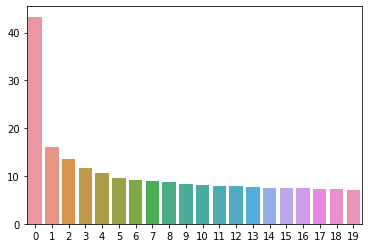

In [ ]:
S = svd.singular_values_
sns.barplot(x=list(range(len(S))), y = S)

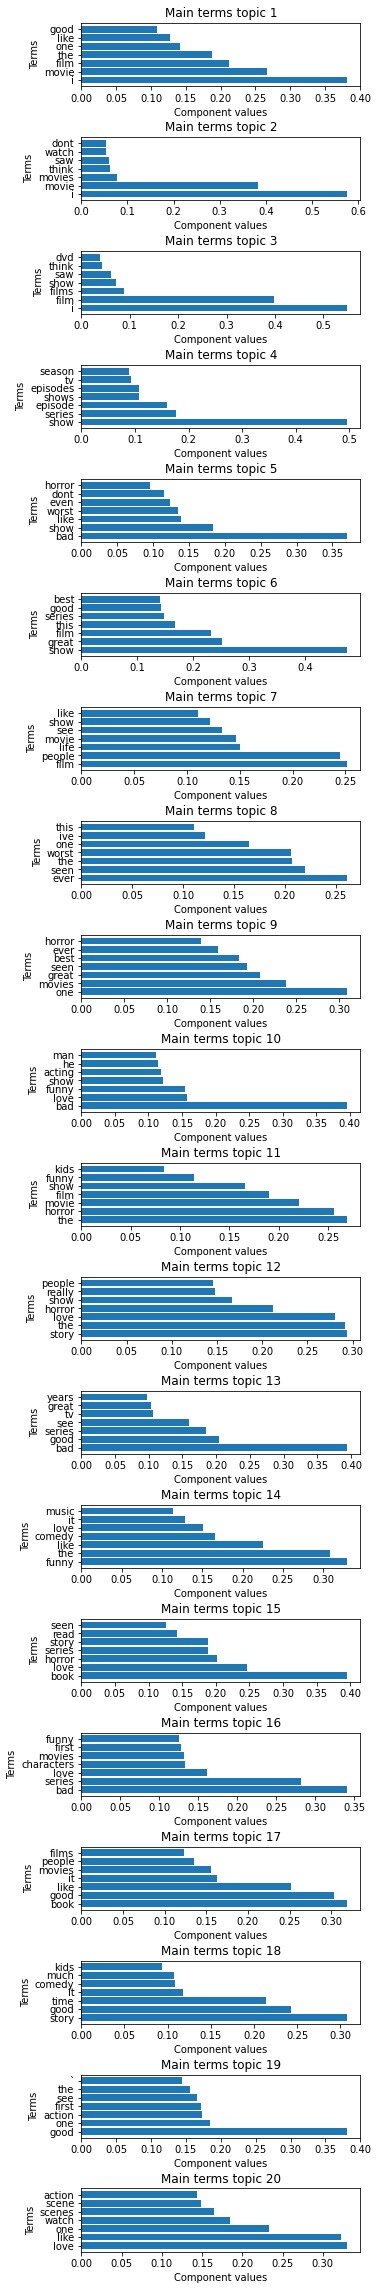

In [ ]:
terms = vsm_tfidf.get_feature_names_out()
topic_terms = get_most_important_words(terms, svd.components_)
plot_term_topic(topic_terms, n_components)

In [ ]:
n = 5
n_examples = 5
lsa_X_train_tfidf = svd.transform(X_train_tfidf)
lsa_X_train_tfidf = sparse.csr_matrix(lsa_X_train_tfidf)

print(lsa_X_train_tfidf.shape)
print_n_most_similar_docs(lsa_X_train_tfidf, X_train_tfidf, vsm_tfidf, n, n_examples)

(35000, 20)
Example 1
Doc:clown listen killers haunted player daughter mountain brings watched warning wish everything writing killed serial help stop dead sick what most fan directing isnt seriously dvd night seen never watch films crap waiting acting actually pacing group tell missing back youve wrong thats house find lot bad how still but movies its people know dont time late go like this could the i

Using Euclidean distance:
clown listen killers haunted player daughter mountain brings watched warning wish everything writing killed serial
moved continued dysfunctional dad farm whenever basement soul died mom san aint nasty collection guess
swear record 210 nightmares stopped commercials price five segment bother each dreams features picked entertaining
balls dubbing fly doctors compelled placed sucks par zombies survive wait r guess turning horribly
evident twelve animal dangerous australian waters 11 aged ruin deaths fifteen shark creatures hundred australia

Using Cosine similari

##### Matriz term x document

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components = 20

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_tfidf.transpose())

TruncatedSVD(n_components=20, random_state=42)

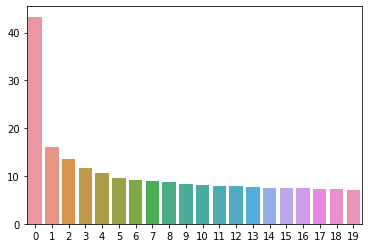

In [ ]:
S = svd.singular_values_
sns.barplot(x=list(range(len(S))), y = S)

In [ ]:
from scipy import sparse
lsa_terms = svd.transform(X_train_tfidf.transpose())
lsa_terms = sparse.csr_matrix(lsa_terms)

In [ ]:
n = 5
n_examples = 5
print_n_most_similar_words(lsa_terms, vsm_tfidf, n, n_examples)

Example 1
Chosen word: alive
Using Euclidean distance:alive victims escape control decide

Using Cosine similarity:alive death trapped inside meat
------------------------------
Example 2
Chosen word: border
Using Euclidean distance:border heroic trade armed wounded

Using Cosine similarity:border forces training army heroic
------------------------------
Example 3
Chosen word: wasting
Using Euclidean distance:wasting 0 warn warned f

Using Cosine similarity:wasting horrible pile paid worse
------------------------------
Example 4
Chosen word: deadly
Using Euclidean distance:deadly hiding trapped escapes attacked

Using Cosine similarity:deadly revenge hiding guard threatening
------------------------------
Example 5
Chosen word: keith
Using Euclidean distance:keith alfred secretary suspects hitchcocks

Using Cosine similarity:keith alfred suspects secretary douglas
------------------------------


#### Classificação

##### TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)
clf.score(X_test_tfidf, y_test)

0.8888666666666667

In [ ]:
n_components = 200

svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(X_train_tfidf)

lsa_X_train_tfidf = svd.transform(X_train_tfidf)
lsa_X_test_tfidf = svd.transform(X_test_tfidf)

clf = LogisticRegression()
clf.fit(lsa_X_train_tfidf, y_train)
clf.score(lsa_X_test_tfidf, y_test)

0.8662666666666666

## Matriz term x term

Como estamos interessados apenas em Representation Learning vamos usar o df completo

### Pointwise Mutual Information

#### Construção da matriz de co-ocorrência

In [ ]:
# from collections import defaultdict

# def get_co_occurrence(sentences, L=5):
#     term_term = defaultdict(int)
#     vocabulary = set()
#     for sentence in tqdm(sentences):
#         tokens = word_tokenize(sentence.lower())
#         for idx, token in enumerate(tokens):
#             vocabulary.add(token)
            
#             left_bound = idx-L if idx-L>0 else 0
#             right_bound = idx + 1 + L
#             contexts = tokens[idx+1 : right_bound]
#             contexts.extend(tokens[left_bound : idx])

#             for context in contexts:
#                 word_context = tuple(sorted([token,context]))
#                 term_term[word_context] += 1
    
    
#     vocabulary = sorted(vocabulary)
#     n_words = len(vocabulary)

#     rowsMatrix = []
#     columnsMatrix = []
#     dataMatrix = []
        
#     for (token1, token2), count in term_term.items():
#         rowsMatrix.append(token1)
#         columnsMatrix.append(token2)
#         dataMatrix.append(count)
#         rowsMatrix.append(token2)
#         columnsMatrix.append(token1)
#         dataMatrix.append(count)

#     return sparse.csr_matrix((dataMatrix, (rowsMatrix, columnsMatrix)))

In [ ]:
# L = 5
# co_occurrence = get_co_occurrence(df['review'], L=L)

In [ ]:
tokenize = lambda x: word_tokenize(x.lower())
sentences = df['review'].progress_apply(word_tokenize)

100%|██████████| 50000/50000 [00:35<00:00, 1420.61it/s]


In [ ]:
sentences

0        [one, reviewers, mentioned, watching, 1, oz, e...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, theres, family, little, boy, jake,...
4        [petter, matteis, love, time, money, visually,...
                               ...                        
49995    [i, thought, movie, right, good, job, it, wasn...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [im, going, disagree, previous, comment, side,...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object

##### Contagem de unigramas

In [ ]:
from collections import Counter 

def getUnigramsCount(sentences) -> Counter():
    unigrams = Counter()
    for sentence in tqdm(sentences):
        for token in sentence:
            unigrams[token] += 1
            
    return unigrams

In [ ]:
unigrams = getUnigramsCount(sentences)
token2index = {token: index for index, token in enumerate(unigrams.keys())}
index2token = {index: token for token, index in token2index.items()}

100%|██████████| 50000/50000 [00:03<00:00, 12575.94it/s]


##### Contagem de Bigramas

In [ ]:
def getSkipGramsCount(
    sentences : str, token2index : dict, gap = 3
) -> Counter():

    # Contador de bigramas, considerando uma determinada janela de contexto (nesse caso, 'gap'
    # palavras antes e 'gap' palavras depois)
    skipgrams = Counter()

    for sentence in tqdm(sentences):
        tokens = [token2index[tok] for tok in sentence]

        # Para cada palavra no parágrafo, realiza a análise dos contextos da vizinhança
        for indexWord, word in enumerate(sentence):
            indexContextMin = max(0, indexWord - gap)
            indexContextMax = min(len(sentence)-1, indexWord + gap)

            # Para cada contexto da vizinhança, crie um bigrama com a palavra central
            indexContexts = [
                index for index in range(indexContextMin, indexContextMax + 1) 
                if index != indexWord
            ]
            for indexContext in indexContexts:
                skipgram = (tokens[indexWord], tokens[indexContext])
                skipgrams[skipgram] += 1
    
    return skipgrams

In [ ]:
skipgrams = getSkipGramsCount(sentences, token2index)

100%|██████████| 50000/50000 [01:03<00:00, 787.08it/s]


#### Removendo algumas palavras

In [ ]:
def removeUnigrams(
    minCount : int, maxCount : int, token2index : dict, index2token : dict, 
    unigrams : Counter(), skipgrams : Counter()
):
    
    # Remoção de tokens muito frequentes ou muito raros
    updatedtoken2index = token2index.copy()
    updatedindex2token = index2token.copy()

    for token in list(unigrams.keys()):
        if unigrams[token] < minCount or unigrams[token] > maxCount:
            del unigrams[token]
            index = token2index[token]
            del updatedtoken2index[token]
            del updatedindex2token[index]
    
    for word, context in list(skipgrams.keys()):
        if index2token[word] not in unigrams or index2token[context] not in unigrams:
            del skipgrams[(word, context)]
    
    return updatedindex2token, updatedtoken2index

In [ ]:
# vocabulary = unigrams.keys()
# print(len(vocabulary))
# minCount, maxCount = (1 / 1000) * len(vocabulary), (1 / 50) * len(vocabulary)
# index2tokenHN, token2indexHN = removeUnigrams(minCount, maxCount, token2index, index2token,
#                                               unigrams, skipgrams)

# print(minCount, maxCount)
# vocabulary = unigrams.keys()
# print(len(vocabulary))

221774
221.774 4435.4800000000005
3547


##### Criação da matriz de co-ocorrência

In [ ]:
def getCountMatrix(skipgrams : Counter()) -> sparse.csr_matrix:
    # Mapeamento das entradas da matriz esparça de frequência entre os bigramas do texto
    rowsMatrix = []
    columnsMatrix = []
    dataMatrix = []

    for (token1, token2), skipgramCount in tqdm(skipgrams.items()):
        rowsMatrix.append(token1)
        columnsMatrix.append(token2)
        dataMatrix.append(skipgramCount)

    return sparse.csr_matrix((dataMatrix, (rowsMatrix, columnsMatrix)))

In [ ]:
wwMatrix = getCountMatrix(skipgrams)

100%|██████████| 3442677/3442677 [00:02<00:00, 1544743.71it/s]


##### Aplicando o reweighting PPMI

In [ ]:
def getPPMImatrix(wwMatrix : sparse.csr_matrix, skipgrams : Counter()) -> sparse.csr_matrix:
    # Número total de bigramas presente na matriz de frequência
    numSkipgrams = wwMatrix.sum()

    # Mapeamento das entradas da matriz PPMI
    rowsIndex = []
    columnsIndex = []
    ppmiData = []

    # Vetor de frequência total de cada palavra em todos os possíveis contextos
    sumWords = np.array(wwMatrix.sum(axis=0)).flatten()

    # Vetor de frequência total de cada contexto para todas as possíveis palavras
    sumContexts = np.array(wwMatrix.sum(axis=1)).flatten()

    for (tokenWord, tokenContext), skipgramCount in tqdm(skipgrams.items()):

        # Frequência de determinada palavra em determinado contexto
        # [#(w,c)]
        freqWordContext = skipgramCount

        # Frequência de determinada palavra em todos os contextos possíveis
        # [#(w)]
        freqWord = sumContexts[tokenWord]

        # Frequência de determinado contexto para todas as palavras possíveis
        # [#(c)]
        freqContext = sumWords[tokenContext]

        # Probabilidade de ocorrência de determinada palavra em determinado contexto
        # [P(w,c)]
        probWordContext = freqWordContext / numSkipgrams

        # Probabilidade de ocorrência de determinada palavra individualmente
        # [P(w)]
        probWord = freqWord / numSkipgrams

        # Probabilidade de ocorrência de determinado contexto individualmente
        # [P(c)]
        probContext = freqContext / numSkipgrams

        # Cálculo PPMI (Positive Pointwise Mutual Information)
        # [PPMI = max(0, log( P(w,c)/(P(w)P(c)) ))]
        PPMI = max(np.log2(probWordContext / (probWord * probContext)), 0)

        rowsIndex.append(tokenWord)
        columnsIndex.append(tokenContext)
        ppmiData.append(PPMI)

    return sparse.csr_matrix((ppmiData, (rowsIndex, columnsIndex)))

In [ ]:
ppmiMatrix = getPPMImatrix(wwMatrix, skipgrams)
vocab_size = len(unigrams)

100%|██████████| 3442677/3442677 [00:12<00:00, 275559.50it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Cálculo dos 10 contextos mais similares a dada palavra utilizando a matriz de Word Embedding
def wordsSimilarity(
    word : str, matrix : np.ndarray, token2index : dict, 
    index2token : dict, n : int
) -> list:
    wordIndex = token2index[word]

    # Resgate do vetor representante de determinada palavra
    if isinstance(matrix, sparse.csr_matrix):
        wordVec = matrix.getrow(wordIndex)
    else:
        wordVec = matrix[wordIndex:wordIndex+1, :]
        

    # Cálculo da similidade (similaridade de vetores por cosseno)
    similarity = cosine_similarity(matrix, wordVec).flatten()
    sortedIndexes = np.argsort(-similarity)

    # Retorno dos n contextos mais similares a dada palavra
    similarityContextScores = [
        (index2token[sortedIndex], similarity[sortedIndex]) 
        for sortedIndex in sortedIndexes[:n+1] 
        if index2token[sortedIndex] != word
    ]

    return similarityContextScores

# Produz uma resenha sobre os contextos mais relacionados a determinada palavra
def wordSimilarityReport(
    word : str, matrix : np.ndarray, unigrams : Counter(), 
    token2index : dict, index2token : dict, n=5
):
    
    print(f'\'{word}\'\t Frequência total: {unigrams[word]}', end='\n')

    similarityContextScores = wordsSimilarity(
        word, matrix, token2index, index2token, n
    )
    
    for context, similarity in similarityContextScores:
        print(f'(\'{context}\', {similarity})', end='\t')

# Expande a lista de contextos similares para determinada palavra
def getExamplesSimilarity(
    examples : list, wordVecs : np.ndarray, unigrams : Counter(),
    token2index : dict, index2token : dict
):
    for word in examples:
        wordSimilarityReport(word, wordVecs, unigrams, token2index, index2token)
        print('\n'+'---'*20)

#### Avaliando similaridade

In [ ]:
'terrible' in vocabulary

True

In [ ]:
examples = [
    'starring', 'star', 'music', 'harry', 'tarantino', 'director', 'theater',
    'wars', 'musical', 'terror', 'awesome', 'terrible', 'series', 'movie',
    'scene'
]
getExamplesSimilarity(
    examples, ppmiMatrix, unigrams, token2index, index2token)


'starring'	 Frequência total: 875
('plays', 0.5127740001931977)	('robert', 0.440197453688079)	('john', 0.43965205721145934)	('directed', 0.4381072515817479)	('actor', 0.42138267556427944)	
------------------------------------------------------------
'star'	 Frequência total: 3526
('stars', 0.45403819514321814)	('john', 0.35761713102473053)	('plays', 0.35478060653787274)	('starring', 0.35413978376575184)	('actor', 0.3348323575862658)	
------------------------------------------------------------
'music'	 Frequência total: 0
('one', 0.0)	('eugene', 0.0)	('garbos', 0.0)	('striking', 0.0)	('pairs', 0.0)	('evies', 0.0)	
------------------------------------------------------------
'harry'	 Frequência total: 750
('plays', 0.3686283108195081)	('john', 0.33656918406755504)	('named', 0.3316277576268914)	('robert', 0.3258015294132891)	('starring', 0.3234898023064477)	
------------------------------------------------------------
'tarantino'	 Frequência total: 0
('one', 0.0)	('eugene', 0.0)	('garbos

#### LSA

In [ ]:
from scipy.sparse.linalg import svds as SVD

def getWordVecs(ppmiMatrix : sparse.csr_matrix, embeddingSize = 50) -> np.ndarray:
    # Dimensão proposta da matriz de valores singulares produzida pelo SVD
    # [Hiperparâmetro]
    embeddingSize = 50

    U, D, V = SVD(ppmiMatrix, embeddingSize)

    # Normalização das matrizes de vetores singulares produzidas pelo SVD
    Unorm = U / np.sqrt(np.sum(U*U, axis=1, keepdims=True))
    Vnorm = V / np.sqrt(np.sum(V*V, axis=1, keepdims=True))

    return Unorm

In [ ]:
word_embeddings = getWordVecs(ppmiMatrix)

In [ ]:
getExamplesSimilarity(
    examples, ppmiMatrix, unigrams, token2index, index2token)

'starring'	 Frequência total: 875
('plays', 0.5127740001931977)	('robert', 0.440197453688079)	('john', 0.43965205721145934)	('directed', 0.4381072515817479)	('actor', 0.42138267556427944)	
------------------------------------------------------------
'star'	 Frequência total: 3526
('stars', 0.45403819514321814)	('john', 0.35761713102473053)	('plays', 0.35478060653787274)	('starring', 0.35413978376575184)	('actor', 0.3348323575862658)	
------------------------------------------------------------
'music'	 Frequência total: 0
('one', 0.0)	('eugene', 0.0)	('garbos', 0.0)	('striking', 0.0)	('pairs', 0.0)	('evies', 0.0)	
------------------------------------------------------------
'harry'	 Frequência total: 750
('plays', 0.3686283108195081)	('john', 0.33656918406755504)	('named', 0.3316277576268914)	('robert', 0.3258015294132891)	('starring', 0.3234898023064477)	
------------------------------------------------------------
'tarantino'	 Frequência total: 0
('one', 0.0)	('eugene', 0.0)	('garbos

#### Visualizando

###### Plotando 2D

In [ ]:
def createWordVecsDataFrame(reducedWordVecs, token2index):
    # Criando um dicionário para cada palavra e seu respectivo vetor após redução de dimensionalidade
    dictReducedWordVecs = {}
    for word, index in token2index.items():
        dictReducedWordVecs[word] = reducedWordVecs[index]

    # Instanciando o dataframe a partir do dicionario criado acima
    dfWordVecs = pd.DataFrame.from_dict(
        data = dictReducedWordVecs,
        orient = 'index',
        columns = ['x', 'y']
    )
    dfWordVecs['word'] = dfWordVecs.index
    
    return dfWordVecs

In [ ]:
# Configurando a ferramenta interativa com o notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

def interativePlot(df, title = None, xlabel = None, ylabel = None):
    # Instancia uma ColumnDAtaSource do Bokeh usando o dataframe
    data = ColumnDataSource(df)

    # Cria o plot e configura:
    # título, dimensões e ferramentas interativas
    plot = figure(
        title= title,
        plot_width=800,
        plot_height=800,
        tools=(
            'pan, wheel_zoom, box_zoom,'
            'box_select, reset',
            HoverTool(tooltips = '@word')
            ),
        active_scroll='wheel_zoom',
        x_axis_label = xlabel,
        y_axis_label = ylabel
        )

    # Desenha os circulos representado as palavras
    plot.circle(
        'x',
        'y',
        source=data,
        color='blue',
        line_alpha=0.2,
        fill_alpha=0.1,
        size=10,
        hover_line_color='black'
        )

    # Configuração de outros detalhes visuais
    plot.xaxis.visible = False
    plot.yaxis.visible = False
    plot.grid.grid_line_color = None
    plot.outline_line_color = None


    show(plot)

In [ ]:
!pip uninstall umap
!pip install umap-learn
import umap.umap_ as umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plotTSNE(wordVecs : np.ndarray, token2index : dict, title : str, sample = 900):
    tsne = TSNE(metric = 'cosine')
    reducedWordVecs = tsne.fit_transform(wordVecs)

    dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
    interativePlot(dfWordVecs.sample(sample, random_state = 42), title = title)

def plotPCA(wordVecs : np.ndarray, token2index : dict, title : str, sample = 900):

    # Realizando redução de dimensão com PCA
    pca = PCA(n_components = 2)
    reducedWordVecs = pca.fit_transform(wordVecs)

    dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
    interativePlot(dfWordVecs.sample(sample, random_state = 42), title = title)

def plotUMAP(reducedWordVecs : np.ndarray, token2index : dict, title : str, sample = 900):

    dfWordVecs = createWordVecsDataFrame(reducedWordVecs, token2index)
    interativePlot(dfWordVecs.sample(sample, random_state = 42), title = title)



In [ ]:
reducer = umap.UMAP(n_components = 2, random_state=42)
reducedWordVecs = reducer.fit_transform(word_embeddings)

In [ ]:
# Realizando redução de dimensão com PCA
plotUMAP(reducedWordVecs, token2index, 'Word embeddings YELP (UMAP)')
# plotPCA(word_embeddings, token2index, 'Word embeddings YELP (PCA)')
# plotTSNE(word_embeddings, token2index, 'Word Vecs YELP dataset (t-SNE)')

IndexError: ignored

##### Dendograma Agrupamento Hierárquico

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Cria um conjunto de palavras considerando as de referência juntamente com as suas n mais similares
def sampleWords(referenceWords, wordVecs, token2index, index2token, n = 5):
    sample = set()
    for word in referenceWords:
        sample.add(word)
        similarityContextScores = wordsSimilarity(word, wordVecs, token2index, index2token, n)
        for context, _ in similarityContextScores:
            sample.add(context)
            
    return sample

def plotDendogram(words, embeddings, title = None, xlabel = None, ylabel = None, figsize = (25,5)):
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # clustering do tipo aglomerativo, usando como critério de agrupamento 
    # a média da distância entre os pontos de um par de cluster, usando o cosseno 
    # como métrica de distância entre os pontos
    link = linkage(embeddings, method = 'average', metric = 'cosine')
    
    dendrogram(
        link,
        labels = words,
        leaf_rotation=90.,  
        leaf_font_size=10.,  
        orientation='top',
    )
    
    plt.show()

In [ ]:
def visualizeDendogram(
    referenceWords : list, wordVecs : np.ndarray, token2index : dict, 
    index2token : dict, title = None, xlabel = None, ylabel = None, figsize = (25,5)
):
    sample = sampleWords(referenceWords, wordVecs, token2index, index2token)

    # Obtem os respectivos Word Embeddings
    embeddings = [wordVecs[token2index[word]] for word in sample]
    
    plotDendogram(list(sample), embeddings, title = 'Dendograma Agrupamento Hierárquico', 
              ylabel = 'distância', xlabel = 'token')

In [ ]:
visualizeDendogram(examples, word_embeddings, token2index, index2token,
                   title = 'Dendograma Agrupamento Hierárquico Brás Cubas', 
                   ylabel = 'distância', xlabel = 'token')